In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
import os, cv2
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.metrics import AUC
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import model_from_json, load_model
from stn import spatial_transformer_network as transformer

In [2]:
df = pd.read_csv('UTKFace.csv')
dim = int(math.sqrt(len(df.pixels[0].split(' '))))
print(df.shape)
df = df.drop(['img_name'], axis=1)
df.head()

(23705, 5)


,age,race,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


In [3]:
df.age.unique()

array([  1,  10, 100, 101, 103, 105,  11, 110, 111, 115, 116,  12,  13,
        14,  15,  16,  17,  18,  19,   2,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,   3,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,   4,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
         5,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,   6,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,   7,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,   8,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,   9,  90,  91,  92,  93,  95,  96,  99],
      dtype=int64)

In [4]:
df.race.unique()

array([2, 3, 4, 0, 1], dtype=int64)

In [5]:
df.gender.unique()

array([0, 1], dtype=int64)

In [6]:
race_dict = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
gender_dict = {0: 'male', 1: 'female'}

In [7]:
df = df.replace({'race': race_dict, 'gender': gender_dict})
df.head()

,age,race,gender,pixels
0,1,asian,male,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,asian,male,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,asian,male,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,asian,male,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,asian,male,202 205 209 210 209 209 210 211 212 214 218 21...


In [8]:
age_count = df.age.value_counts()
print(age_count)

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
111       1
103       1
Name: age, Length: 104, dtype: int64


In [9]:
df['age_group'] = pd.cut(x=df['age'], bins=[0,20,25,30,40,60,116], labels=['<20','20-25','25-30','30-40','40-60','>60'])
df.head()
age_count = df.age_group.value_counts()
print(age_count)

25-30    5024
<20      4877
30-40    4338
40-60    4311
20-25    2760
>60      2395
Name: age_group, dtype: int64


In [10]:
gender_count = df.gender.value_counts()
print(gender_count)

male      12391
female    11314
Name: gender, dtype: int64


In [11]:
race_count = df.race.value_counts()
print(race_count)

white     10078
black      4526
indian     3975
asian      3434
others     1692
Name: race, dtype: int64


<AxesSubplot:ylabel='age_group'>

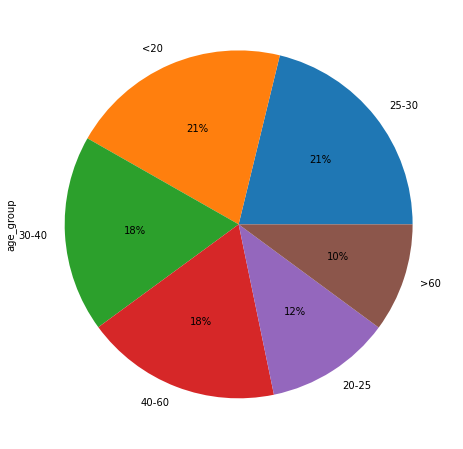

In [12]:
age_count.plot(kind='pie', autopct='%1.0f%%', figsize=(8, 8))

<AxesSubplot:ylabel='gender'>

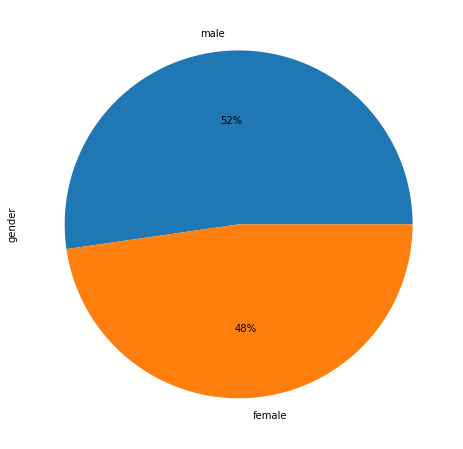

In [13]:
gender_count.plot(kind='pie', autopct='%1.0f%%', figsize=(8, 8))

<AxesSubplot:ylabel='race'>

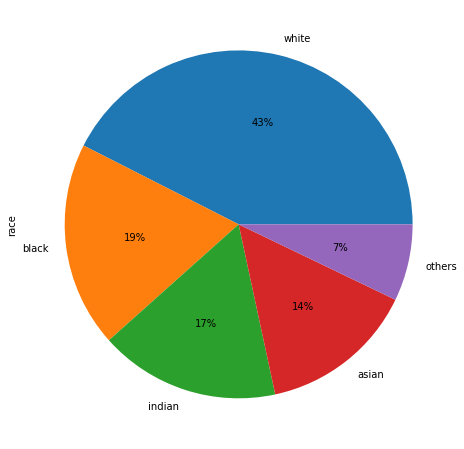

In [14]:
race_count.plot(kind='pie', autopct='%1.0f%%', figsize=(8, 8))

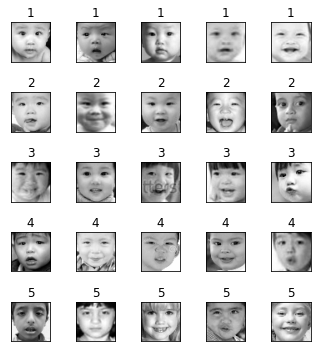

In [15]:
plt.figure(figsize=(5, 5))
count = 0
for label in sorted(df.age.unique()):
    for i in range(5):
        if count < 25:
            px = df[df.age==label].pixels.iloc[count]
            px = np.array(px.split(' ')).reshape(dim, dim).astype('float32')
            count += 1
            ax = plt.subplot(5, 5, count)
            ax.imshow(px, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(label)
            plt.tight_layout()

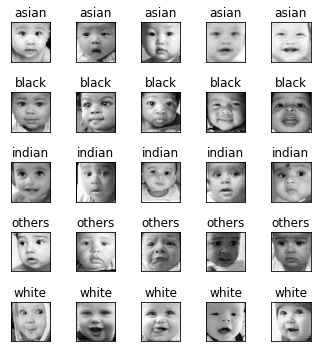

In [16]:
plt.figure(figsize=(5, 5))
count = 0
for label in sorted(df.race.unique()):
    for i in range(5):
        if count < 25:
            px = df[df.race==label].pixels.iloc[count]
            px = np.array(px.split(' ')).reshape(dim, dim).astype('float32')
            count += 1
            ax = plt.subplot(5, 5, count)
            ax.imshow(px, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(label)
            plt.tight_layout()

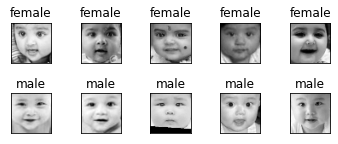

In [17]:
plt.figure(figsize=(5, 5))
count = 0
for label in sorted(df.gender.unique()):
    for i in range(5):
        if count < 25:
            px = df[df.gender==label].pixels.iloc[count]
            px = np.array(px.split(' ')).reshape(dim, dim).astype('float32')
            count += 1
            ax = plt.subplot(5, 5, count)
            ax.imshow(px, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(label)
            plt.tight_layout()

In [18]:
img_df = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(dim, dim, 1).astype('float32'))
img_df = np.stack(img_df, axis=0)

In [19]:
img_df.shape

(23705, 48, 48, 1)

In [20]:
class STN(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(STN, self).__init__(**kwargs)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv1 = tf.keras.layers.Conv2D(32, [5, 5], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(64, [5, 5], activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(12, activation='relu')
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 6]

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        theta = self.fc2(x)
        out = transformer(inputs, theta)
        return out

In [21]:
def age_pred(lables):

    img_labels = lables
    le = LabelEncoder()
    img_labels = le.fit_transform(img_labels)
    img_labels = np_utils.to_categorical(img_labels)
   
    X_train, X_test, y_train, y_test = train_test_split(img_df, img_labels, shuffle=True, test_size=0.25, random_state=42)
#     X_train.shape, X_test.shape, y_train.shape, y_test.shape
    X_train = X_train / 255.
    X_test = X_test / 255.
    class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
    class_weights = dict(enumerate(class_weights))
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    image = tf.keras.layers.Input(shape=input_shape)
    x = STN()(image)
   
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=input_shape,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)


    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Flatten()(x)
        
    x = tf.keras.layers.Dense(
        256,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        128,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        6,
        activation='softmax',
    )(x)
    
    stn_model_age = tf.keras.models.Model(inputs=image, outputs=x)

    es_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.0001)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=1e-7, verbose=1)
    checkpoint = ModelCheckpoint(filepath='saved_models/best_weight_UTK_age.h5', mode='max', monitor='val_accuracy', verbose=1, save_best_only=True)
    
    batch_size = 32

    stn_model_age.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), 
                  metrics=['accuracy', AUC(multi_label=True, num_labels=6)])
    stn_result_age = stn_model_age.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size, steps_per_epoch=len(X_train)/batch_size, 
              epochs=60, callbacks=[checkpoint, reduce_lr], class_weight=class_weights)
    
    age_model_json = stn_model_age.to_json()
    with open("saved_models/age_utk_model.json", "w") as json_file:
        json_file.write(age_model_json)
        
    age_list = ['<20', '20-25', '25-30', '30-40', '40-60', '>60']
    pred_class = stn_model_age.predict(X_test)
    rounded_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(rounded_labels, np.argmax(np.round(pred_class), axis=1))
    print("Classification Report:\n")
    cr = classification_report(rounded_labels, np.argmax(np.round(pred_class), axis=1), 
                                target_names=[age_list[i] for i in range(len(age_list))])
    print(cr)
    plt.figure(figsize=(12, 12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels=[age_list[i] for i in range(len(age_list))], 
                yticklabels=[age_list[i] for i in range(len(age_list))], fmt="d")
    fig = sns_hmp.get_figure()
        
    return stn_result_age

In [22]:
def get_age_graphs(stn_result):
    loss = stn_result.history['loss']
    val_loss = stn_result.history['val_loss']

    acc = stn_result.history['accuracy'] 
    val_acc = stn_result.history['val_accuracy']

    # top5_acc = stn_model.history['top5 acc']
    # val_top5_acc = stn_model.history['val_top5 acc']
    epochs = range(len(loss))

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.yscale('log')
    plt.plot(epochs, loss, linewidth=3, alpha=0.7, label='Train Loss')
    plt.plot(epochs, val_loss, linewidth=2, alpha=0.8, label='Valid Loss')
    # plt.ylim(0.3, 100)
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, acc, linewidth=3, alpha=0.7, label='Train Acc')
    plt.plot(epochs, val_acc, linewidth=2, alpha=0.8, label='Valid Acc') 
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    # plt.subplot(1, 3, 3)
    # plt.plot(epochs, top5_acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Top 5 Acc')
    # plt.plot(epochs, val_top5_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Top5 Acc') 
    # plt.xlabel('Epochs', fontsize=11)
    # plt.ylabel('Top5 Accuracy', fontsize=12)
    # plt.legend(fontsize=12)
    plt.tight_layout()
    # plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
    plt.show()

In [23]:
# def get_stn_model(input_shape):
    
#     image = tf.keras.layers.Input(shape=input_shape)
#     x = STN()(image)
   
#     x = tf.keras.layers.Conv2D(
#         filters=64,
#         kernel_size=(5,5),
#         input_shape=input_shape,
#         activation='relu',
#         padding='same',
#         kernel_initializer='he_normal',
#     )(x)
    
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     x = tf.keras.layers.Conv2D(
#         filters=64,
#         kernel_size=(5,5),
#         activation='relu',
#         padding='same',
#         kernel_initializer='he_normal',
#     )(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
#     x = tf.keras.layers.Dropout(0.4)(x)


#     x = tf.keras.layers.Conv2D(
#         filters=128,
#         kernel_size=(3,3),
#         activation='relu',
#         padding='same',
#         kernel_initializer='he_normal',
#     )(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     x = tf.keras.layers.Conv2D(
#         filters=128,
#         kernel_size=(3,3),
#         activation='relu',
#         padding='same',
#         kernel_initializer='he_normal',
#     )(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
#     x = tf.keras.layers.Dropout(0.4)(x)

#     x = tf.keras.layers.Conv2D(
#         filters=256,
#         kernel_size=(3,3),
#         activation='relu',
#         padding='same',
#         kernel_initializer='he_normal',
#     )(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     x = tf.keras.layers.Conv2D(
#         filters=256,
#         kernel_size=(3,3),
#         activation='relu',
#         padding='same',
#         kernel_initializer='he_normal',
#     )(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
#     x = tf.keras.layers.Dropout(0.5)(x)

#     x = tf.keras.layers.Flatten()(x)
        
#     x = tf.keras.layers.Dense(
#         256,
#         activation='relu',
#         kernel_initializer='he_normal',
#         kernel_regularizer=tf.keras.regularizers.l2(0.01),
#         bias_regularizer=tf.keras.regularizers.l2(0.01)
#     )(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(0.3)(x)
    
#     x = tf.keras.layers.Dense(
#         512,
#         activation='relu',
#         kernel_initializer='he_normal',
#         kernel_regularizer=tf.keras.regularizers.l2(0.01),
#         bias_regularizer=tf.keras.regularizers.l2(0.01)
#     )(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(0.3)(x)
    
#     x = tf.keras.layers.Dense(
#         8,
#         activation='softmax',
#     )(x)
    
#     return tf.keras.models.Model(inputs=image, outputs=x)

In [24]:
# es_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.0001)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_lr=1e-7, verbose=1)
# checkpoint = ModelCheckpoint(filepath='saved_models/best_weight_CK+.h5', mode='max', monitor='val_accuracy', verbose=1, save_best_only=True)

In [25]:
# batch_size = 32
# stn_model_age = age_pred(df.age)

# stn_model_age.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), 
#                   metrics=['mae'])
# stn_result_age = stn_model_age.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size, steps_per_epoch=len(X_train)/batch_size, 
#               epochs=60, callbacks=[checkpoint, es_callback])

Building Localization Network with input shape: (None, 48, 48, 1)
Epoch 1/60
554/555 [============================>.] - ETA: 0s - loss: 2.2224 - accuracy: 0.3350 - auc: 0.6837
Epoch 1: val_accuracy improved from -inf to 0.29921, saving model to saved_models\best_weight_UTK_age.h5
555/555 [==============================] - 27s 26ms/step - loss: 2.2173 - accuracy: 0.3349 - auc: 0.6840 - val_loss: 2.2058 - val_accuracy: 0.2992 - val_auc: 0.7190 - lr: 0.0010
Epoch 2/60
555/555 [============================>.] - ETA: 0s - loss: 0.6146 - accuracy: 0.4208 - auc: 0.7812
Epoch 2: val_accuracy improved from 0.29921 to 0.33240, saving model to saved_models\best_weight_UTK_age.h5
555/555 [==============================] - 13s 24ms/step - loss: 0.6144 - accuracy: 0.4208 - auc: 0.7813 - val_loss: 2.0774 - val_accuracy: 0.3324 - val_auc: 0.7548 - lr: 0.0010
Epoch 3/60
556/555 [==============================] - ETA: 0s - loss: 0.5114 - accuracy: 0.4481 - auc: 0.8083
Epoch 3: val_accuracy did not impro

555/555 [============================>.] - ETA: 0s - loss: 0.4033 - accuracy: 0.5655 - auc: 0.8815
Epoch 23: val_accuracy did not improve from 0.56749
555/555 [==============================] - 13s 23ms/step - loss: 0.4033 - accuracy: 0.5655 - auc: 0.8815 - val_loss: 1.6630 - val_accuracy: 0.4640 - val_auc: 0.8238 - lr: 0.0010
Epoch 24/60
555/555 [============================>.] - ETA: 0s - loss: 0.3972 - accuracy: 0.5680 - auc: 0.8825
Epoch 24: val_accuracy improved from 0.56749 to 0.57705, saving model to saved_models\best_weight_UTK_age.h5
555/555 [==============================] - 13s 23ms/step - loss: 0.3972 - accuracy: 0.5682 - auc: 0.8825 - val_loss: 1.1733 - val_accuracy: 0.5771 - val_auc: 0.8878 - lr: 0.0010
Epoch 25/60
556/555 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.5762 - auc: 0.8855
Epoch 25: val_accuracy did not improve from 0.57705
555/555 [==============================] - 13s 23ms/step - loss: 0.3842 - accuracy: 0.5762 - auc: 0.8855 - val

Epoch 46/60
555/555 [============================>.] - ETA: 0s - loss: 0.2021 - accuracy: 0.7072 - auc: 0.9377
Epoch 46: val_accuracy did not improve from 0.59561
555/555 [==============================] - 13s 23ms/step - loss: 0.2022 - accuracy: 0.7072 - auc: 0.9377 - val_loss: 1.1967 - val_accuracy: 0.5759 - val_auc: 0.8820 - lr: 2.0000e-04
Epoch 47/60
554/555 [============================>.] - ETA: 0s - loss: 0.2011 - accuracy: 0.7079 - auc: 0.9397
Epoch 47: val_accuracy did not improve from 0.59561
555/555 [==============================] - 13s 24ms/step - loss: 0.2011 - accuracy: 0.7077 - auc: 0.9397 - val_loss: 1.1461 - val_accuracy: 0.5832 - val_auc: 0.8854 - lr: 2.0000e-04
Epoch 48/60
554/555 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.7064 - auc: 0.9392
Epoch 48: val_accuracy did not improve from 0.59561
555/555 [==============================] - 13s 23ms/step - loss: 0.2035 - accuracy: 0.7062 - auc: 0.9391 - val_loss: 1.1769 - val_accuracy: 0.5877 

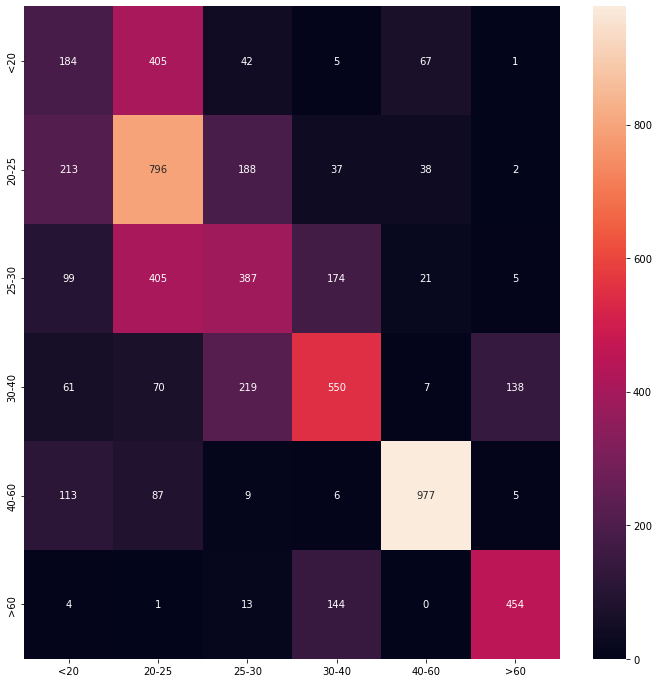

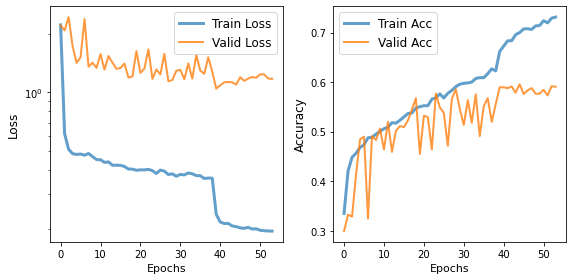

In [26]:
age_result = age_pred(df.age_group)
get_age_graphs(age_result)

In [27]:
def gender_pred(lables):

    img_labels = lables
    le = LabelEncoder()
    img_labels = le.fit_transform(df.gender)
    img_labels = np_utils.to_categorical(img_labels)
#     img_labels.shape
   
    X_train, X_test, y_train, y_test = train_test_split(img_df, img_labels, shuffle=True, test_size=0.25, random_state=42)
#     X_train.shape, X_test.shape, y_train.shape, y_test.shape
    X_train = X_train / 255.
    X_test = X_test / 255.
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    image = tf.keras.layers.Input(shape=input_shape)
    x = STN()(image)
   
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=input_shape,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)


    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Flatten()(x)
        
    x = tf.keras.layers.Dense(
        256,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        128,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        2,
        activation='softmax',
    )(x)
    
    stn_model_gender = tf.keras.models.Model(inputs=image, outputs=x)

    es_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.0001)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=1e-7, verbose=1)
    checkpoint = ModelCheckpoint(filepath='saved_models/best_weight_UTK_gender.h5', mode='max', monitor='val_accuracy', verbose=1, save_best_only=True)
    
    batch_size = 128

    stn_model_gender.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), 
                  metrics=['accuracy', AUC(multi_label=True, num_labels=2)])
    stn_result_gender = stn_model_gender.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size, steps_per_epoch=len(X_train)/batch_size, 
              epochs=60, callbacks=[checkpoint, es_callback, reduce_lr])
    
    gender_model_json = stn_model_gender.to_json()
    with open("saved_models/gender_utk_model.json", "w") as json_file:
        json_file.write(gender_model_json)
        
    gender_list = ['male', 'female']
    pred_class = stn_model_gender.predict(X_test)
    rounded_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(rounded_labels, np.argmax(np.round(pred_class), axis=1))
    print("Classification Report:\n")
    cr = classification_report(rounded_labels, np.argmax(np.round(pred_class), axis=1), 
                                target_names=[gender_list[i] for i in range(len(gender_list))])
    print(cr)
    plt.figure(figsize=(12, 12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels=[gender_list[i] for i in range(len(gender_list))], 
                yticklabels=[gender_list[i] for i in range(len(gender_list))], fmt="d")
    fig = sns_hmp.get_figure()
        
    return stn_result_gender

In [28]:
def get_gender_graphs(stn_result):
    loss = stn_result.history['loss']
    val_loss = stn_result.history['val_loss']

    acc = stn_result.history['accuracy'] 
    val_acc = stn_result.history['val_accuracy']

    # top5_acc = stn_model.history['top5 acc']
    # val_top5_acc = stn_model.history['val_top5 acc']
    epochs = range(len(loss))

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.yscale('log')
    plt.plot(epochs, loss, linewidth=3, alpha=0.7, label='Train Loss')
    plt.plot(epochs, val_loss, linewidth=2, alpha=0.8, label='Valid Loss')
    # plt.ylim(0.3, 100)
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, acc, linewidth=3, alpha=0.7, label='Train Acc')
    plt.plot(epochs, val_acc, linewidth=2, alpha=0.8, label='Valid Acc') 
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    # plt.subplot(1, 3, 3)
    # plt.plot(epochs, top5_acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Top 5 Acc')
    # plt.plot(epochs, val_top5_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Top5 Acc') 
    # plt.xlabel('Epochs', fontsize=11)
    # plt.ylabel('Top5 Accuracy', fontsize=12)
    # plt.legend(fontsize=12)
    plt.tight_layout()
    # plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
    plt.show()

Building Localization Network with input shape: (None, 48, 48, 1)
Epoch 1/60
139/138 [==============================] - ETA: 0s - loss: 5.4740 - accuracy: 0.7396 - auc_1: 0.8106
Epoch 1: val_accuracy improved from -inf to 0.80540, saving model to saved_models\best_weight_UTK_gender.h5
138/138 [==============================] - 15s 86ms/step - loss: 5.4740 - accuracy: 0.7396 - auc_1: 0.8106 - val_loss: 2.7225 - val_accuracy: 0.8054 - val_auc_1: 0.9152 - lr: 0.0010
Epoch 2/60
139/138 [==============================] - ETA: 0s - loss: 1.7252 - accuracy: 0.8252 - auc_1: 0.9109
Epoch 2: val_accuracy improved from 0.80540 to 0.86277, saving model to saved_models\best_weight_UTK_gender.h5
138/138 [==============================] - 9s 68ms/step - loss: 1.7252 - accuracy: 0.8252 - auc_1: 0.9109 - val_loss: 1.0883 - val_accuracy: 0.8628 - val_auc_1: 0.9370 - lr: 0.0010
Epoch 3/60
139/138 [==============================] - ETA: 0s - loss: 0.8968 - accuracy: 0.8472 - auc_1: 0.9294
Epoch 3: val_acc

Epoch 23/60
139/138 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.9225 - auc_1: 0.9771
Epoch 23: val_accuracy did not improve from 0.91395
138/138 [==============================] - 9s 65ms/step - loss: 0.4446 - accuracy: 0.9225 - auc_1: 0.9771 - val_loss: 0.4967 - val_accuracy: 0.9049 - val_auc_1: 0.9723 - lr: 0.0010
Epoch 24/60
139/138 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.9286 - auc_1: 0.9799
Epoch 24: val_accuracy did not improve from 0.91395
138/138 [==============================] - 9s 67ms/step - loss: 0.4455 - accuracy: 0.9286 - auc_1: 0.9799 - val_loss: 0.5169 - val_accuracy: 0.9049 - val_auc_1: 0.9722 - lr: 0.0010
Epoch 25/60
139/138 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.9278 - auc_1: 0.9800
Epoch 25: val_accuracy did not improve from 0.91395
138/138 [==============================] - 9s 66ms/step - loss: 0.4603 - accuracy: 0.9278 - auc_1: 0.9800 - val_loss: 0.4707 - val_accuracy: 0.

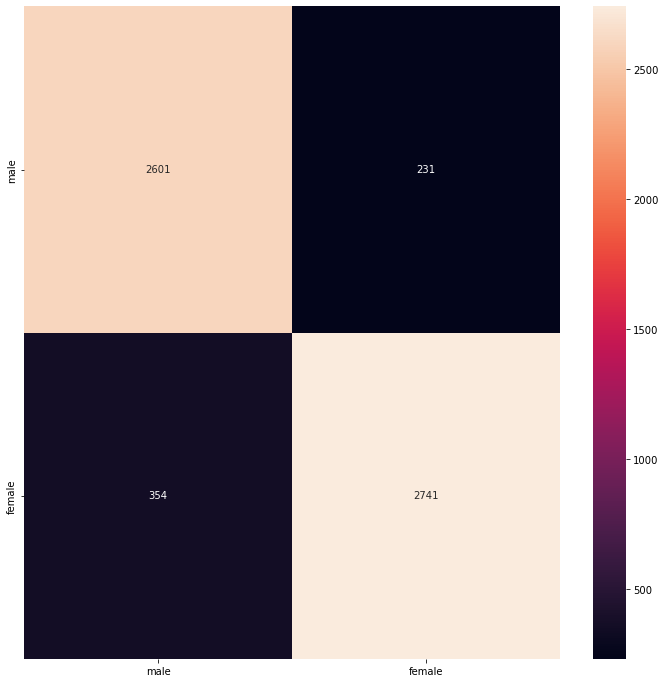

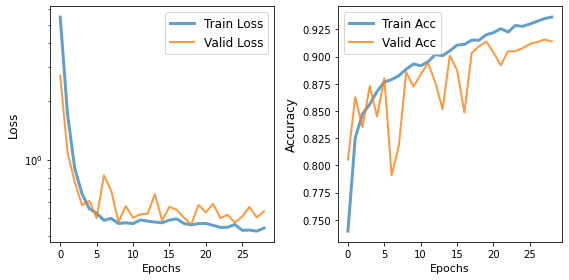

In [29]:
gender_result = gender_pred(df.gender)
get_gender_graphs(gender_result)

In [30]:
def race_pred(lables):

    img_labels = lables
    le = LabelEncoder()
    img_labels = le.fit_transform(df.race)
    img_labels = np_utils.to_categorical(img_labels)
#     img_labels.shape
   
    X_train, X_test, y_train, y_test = train_test_split(img_df, img_labels, shuffle=True, test_size=0.25, random_state=42)
#     X_train.shape, X_test.shape, y_train.shape, y_test.shape
    X_train = X_train / 255.
    X_test = X_test / 255.
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    image = tf.keras.layers.Input(shape=input_shape)
    x = STN()(image)
   
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=input_shape,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)


    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Flatten()(x)
        
    x = tf.keras.layers.Dense(
        256,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        128,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        5,
        activation='softmax',
    )(x)
    
    stn_model_race = tf.keras.models.Model(inputs=image, outputs=x)

    es_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.0001)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=1e-7, verbose=1)
    checkpoint = ModelCheckpoint(filepath='saved_models/best_weight_UTK_race.h5', mode='max', monitor='val_accuracy', verbose=1, save_best_only=True)
    
    batch_size = 64

    stn_model_race.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), 
                  metrics=['accuracy', AUC(multi_label=True, num_labels=5)])
    stn_result_race = stn_model_race.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size, steps_per_epoch=len(X_train)/batch_size, 
              epochs=60, callbacks=[checkpoint, reduce_lr])
    
    race_model_json = stn_model_race.to_json()
    with open("saved_models/race_utk_model.json", "w") as json_file:
        json_file.write(race_model_json)
        
    race_list = ['white', 'black', 'asian', 'indian', 'others']
    pred_class = stn_model_race.predict(X_test)
    rounded_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(rounded_labels, np.argmax(np.round(pred_class), axis=1))
    print("Classification Report:\n")
    cr = classification_report(rounded_labels, np.argmax(np.round(pred_class), axis=1), 
                                target_names=[race_list[i] for i in range(len(race_list))])
    print(cr)
    plt.figure(figsize=(12, 12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels=[race_list[i] for i in range(len(race_list))], 
                yticklabels=[race_list[i] for i in range(len(race_list))], fmt="d")
    fig = sns_hmp.get_figure()
        
    return stn_result_race

In [31]:
def get_race_graphs(stn_result):
    loss = stn_result.history['loss']
    val_loss = stn_result.history['val_loss']

    acc = stn_result.history['accuracy'] 
    val_acc = stn_result.history['val_accuracy']

    # top5_acc = stn_model.history['top5 acc']
    # val_top5_acc = stn_model.history['val_top5 acc']
    epochs = range(len(loss))

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.yscale('log')
    plt.plot(epochs, loss, linewidth=3, alpha=0.7, label='Train Loss')
    plt.plot(epochs, val_loss, linewidth=2, alpha=0.8, label='Valid Loss')
    # plt.ylim(0.3, 100)
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, acc, linewidth=3, alpha=0.7, label='Train Acc')
    plt.plot(epochs, val_acc, linewidth=2, alpha=0.8, label='Valid Acc') 
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    # plt.subplot(1, 3, 3)
    # plt.plot(epochs, top5_acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Top 5 Acc')
    # plt.plot(epochs, val_top5_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Top5 Acc') 
    # plt.xlabel('Epochs', fontsize=11)
    # plt.ylabel('Top5 Accuracy', fontsize=12)
    # plt.legend(fontsize=12)
    plt.tight_layout()
    # plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
    plt.show()

Building Localization Network with input shape: (None, 48, 48, 1)
Epoch 1/60
277/277 [============================>.] - ETA: 0s - loss: 5.9703 - accuracy: 0.5164 - auc_2: 0.7392
Epoch 1: val_accuracy improved from -inf to 0.59843, saving model to saved_models\best_weight_UTK_race.h5
277/277 [==============================] - 15s 44ms/step - loss: 5.9603 - accuracy: 0.5167 - auc_2: 0.7395 - val_loss: 3.2928 - val_accuracy: 0.5984 - val_auc_2: 0.8255 - lr: 0.0010
Epoch 2/60
277/277 [============================>.] - ETA: 0s - loss: 2.3493 - accuracy: 0.6641 - auc_2: 0.8475
Epoch 2: val_accuracy improved from 0.59843 to 0.69179, saving model to saved_models\best_weight_UTK_race.h5
277/277 [==============================] - 10s 37ms/step - loss: 2.3471 - accuracy: 0.6643 - auc_2: 0.8475 - val_loss: 1.8062 - val_accuracy: 0.6918 - val_auc_2: 0.8784 - lr: 0.0010
Epoch 3/60
277/277 [============================>.] - ETA: 0s - loss: 1.5852 - accuracy: 0.7042 - auc_2: 0.8744
Epoch 3: val_accura

Epoch 23/60
277/277 [============================>.] - ETA: 0s - loss: 1.0433 - accuracy: 0.8340 - auc_2: 0.9480
Epoch 23: val_accuracy did not improve from 0.80877
277/277 [==============================] - 10s 37ms/step - loss: 1.0434 - accuracy: 0.8341 - auc_2: 0.9480 - val_loss: 1.2025 - val_accuracy: 0.7975 - val_auc_2: 0.9311 - lr: 0.0010
Epoch 24/60
277/277 [============================>.] - ETA: 0s - loss: 1.0261 - accuracy: 0.8338 - auc_2: 0.9490
Epoch 24: val_accuracy did not improve from 0.80877
277/277 [==============================] - 10s 37ms/step - loss: 1.0261 - accuracy: 0.8337 - auc_2: 0.9491 - val_loss: 1.1610 - val_accuracy: 0.7992 - val_auc_2: 0.9293 - lr: 0.0010
Epoch 25/60
277/277 [============================>.] - ETA: 0s - loss: 1.0497 - accuracy: 0.8412 - auc_2: 0.9529
Epoch 25: val_accuracy did not improve from 0.80877
277/277 [==============================] - 10s 37ms/step - loss: 1.0504 - accuracy: 0.8410 - auc_2: 0.9526 - val_loss: 1.1904 - val_accuracy:

277/277 [==============================] - 11s 41ms/step - loss: 0.4063 - accuracy: 0.9355 - auc_2: 0.9908 - val_loss: 0.9112 - val_accuracy: 0.8161 - val_auc_2: 0.9324 - lr: 2.0000e-04
Epoch 46/60
277/277 [============================>.] - ETA: 0s - loss: 0.3911 - accuracy: 0.9383 - auc_2: 0.9921
Epoch 46: val_accuracy did not improve from 0.82790
277/277 [==============================] - 12s 43ms/step - loss: 0.3914 - accuracy: 0.9382 - auc_2: 0.9921 - val_loss: 0.9053 - val_accuracy: 0.8195 - val_auc_2: 0.9313 - lr: 2.0000e-04
Epoch 47/60
277/277 [============================>.] - ETA: 0s - loss: 0.3911 - accuracy: 0.9404 - auc_2: 0.9915
Epoch 47: val_accuracy did not improve from 0.82790
277/277 [==============================] - 11s 39ms/step - loss: 0.3915 - accuracy: 0.9403 - auc_2: 0.9915 - val_loss: 0.9420 - val_accuracy: 0.8121 - val_auc_2: 0.9314 - lr: 2.0000e-04
Epoch 48/60
277/277 [============================>.] - ETA: 0s - loss: 0.3851 - accuracy: 0.9424 - auc_2: 0.9926

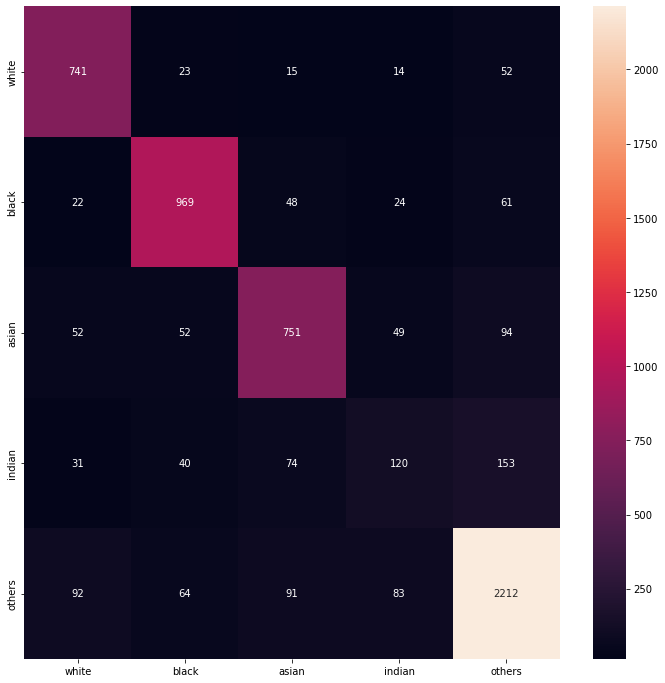

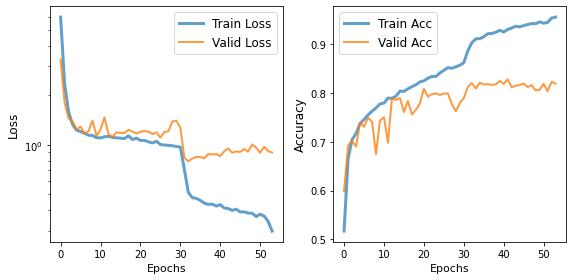

In [32]:
race_result = race_pred(df.race)
get_race_graphs(race_result)